## Required module and library 

In [3]:
import pandas as pd
import numpy as np
from nltk import word_tokenize,sent_tokenize,RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV
from nltk.util import ngrams

## Loading the dataset 

In [4]:
df = pd.read_csv("fake_or_real_news.csv")


## Description of each column 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [6]:
df['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

## Top 5 rows with longest title  

In [7]:
descending = df.sort_values(by='text', key=lambda x: x.str.len(), ascending=False)
descending['length_of_title']= descending['title'].str.len()
print(descending[:5])

      Unnamed: 0                                              title  \
4733        7910  Re: Why Are So Many People Choosing To Leave T...   
3436        5765  Re: It Is Now Mathematically Impossible To Pay...   
1359        5604  Benny Morris’s Untenable Denial of the Ethnic ...   
536         9618   President Putin Asks US To Stop Provoking Russia   
3685        8441  Re: America Has Become A Lawless Nation – Hill...   

                                                   text label  length_of_title  
4733  Why Are So Many People Choosing To Leave The U...  FAKE               75  
3436  It Is Now Mathematically Impossible To Pay Off...  FAKE               73  
1359  References The Debate \r\nIt started when Dani...  FAKE               68  
536   Here is President Putin’s speech at Valdai Put...  FAKE               48  
3685  America Has Become A Lawless Nation – Hillary ...  FAKE               86  


## Visualizing No. of real and fake news 

Text(0.5, 0, 'fake or real ')

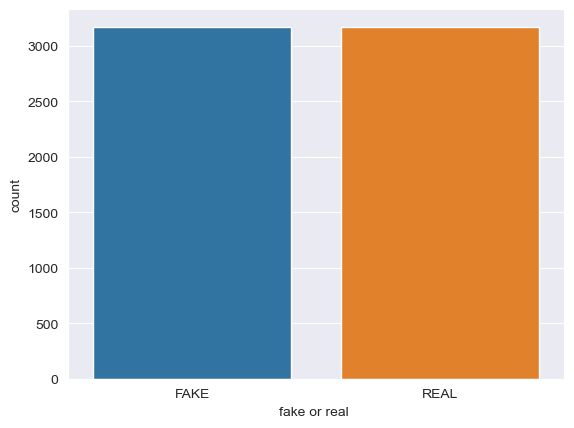

In [8]:
sns.countplot(x ='label',data = df)
plt.xlabel("fake or real ")

In [ ]:
### The data are balanced no need to perform transformation 

                                                         ## Top 10 most frequent words in the data set 

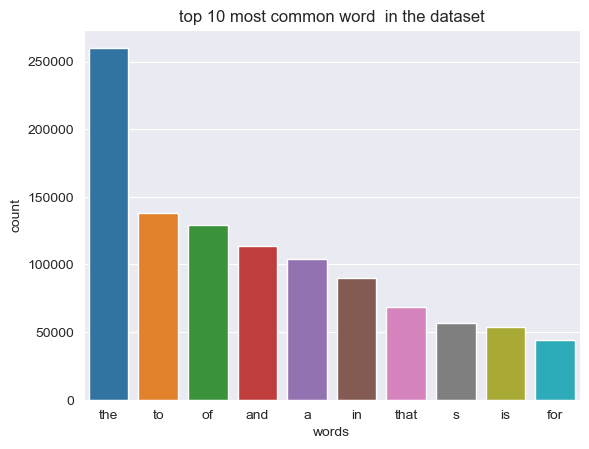

In [9]:

text = [sent_tokenize(text) for text in df['text']]
tokenizer = RegexpTokenizer(r'\w+')
text_list=[[tokenizer.tokenize(sentence) for sentence in sentences] for sentences in text]
corpus  = [word for sublist in text_list for sentence in sublist for word in sentence]
def count_graph(corpus):
    counter = Counter(corpus)
    word,word_count  =  [],[]
    most= counter.most_common()
    for i,j in  most[:10]:
        word.append(i)
        word_count.append(j)

    sns.barplot(x=word,y =word_count)
    plt.title("top 10 most common word  in the dataset")
    plt.xlabel("words")
    plt.ylabel("count")
count_graph(corpus)

## Top 10 most frequent words in the data set after removing stop word

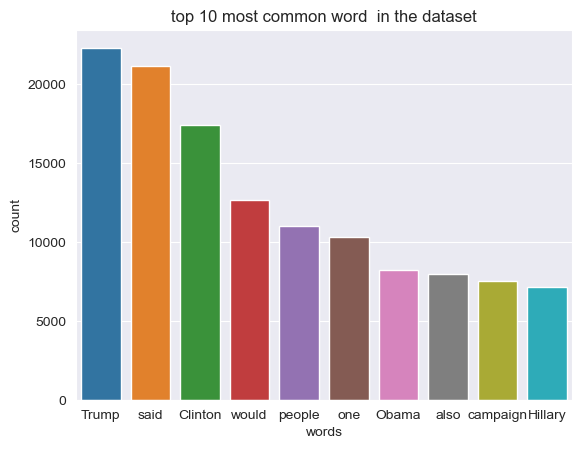

In [10]:
stop_words = stopwords.words('english')
text_list = [[word for word in tokenizer.tokenize(sentence) if word.lower() not in stop_words] for sentences in text for sentence in sentences]

# Flatten the list of lists to get a single list of words
corpus1 = [word for sentence in text_list for word in sentence]
count_graph(corpus1)

## Word cloud before normalization

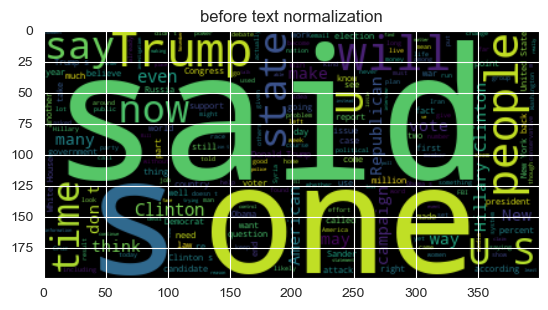

In [11]:

string_text = ' '.join(corpus)
stopwords = set(STOPWORDS)
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords).generate(string_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear' )
plt.title("before text normalization")
plt.show()

## Word cloud after text normalization lemitization

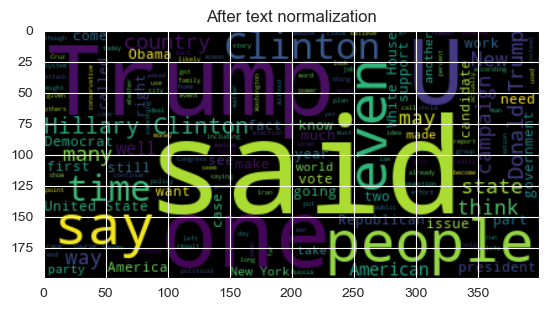

In [12]:

lemmatizer = WordNetLemmatizer()
lemmatized_sentences = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in text_list]
# Flatten list
corpus_lem = [word for sublist in lemmatized_sentences for word in sublist] 
string_lem = ' '.join(corpus_lem)
wordcloud = WordCloud(stopwords = stopwords).generate(string_lem)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear' )
plt.title("After text normalization")
plt.show()

### bigram 

In [13]:
def get_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

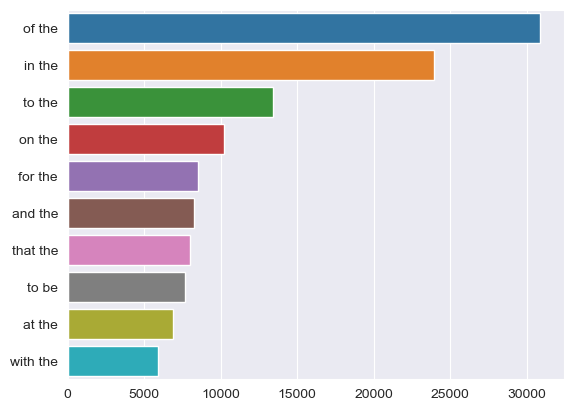

In [14]:
bigrams = get_ngram(df['text'],2)[:10]
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x)

## Trigram

<Axes: >

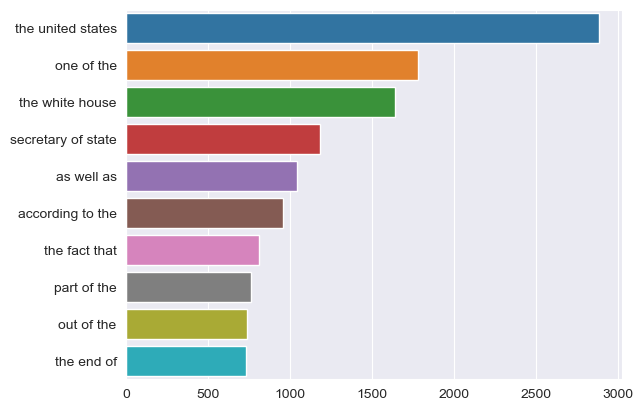

In [15]:
trigrams = get_ngram(df['text'],3)[:10]
x,y=map(list,zip(*trigrams))
sns.barplot(x=y,y=x)

## pos tagging

[Text(0, 0, 'Noun'),
 Text(1, 0, 'proper noun, singular'),
 Text(2, 0, 'adjective'),
 Text(3, 0, 'noun plural'),
 Text(4, 0, 'past tense verb'),
 Text(5, 0, 'adverb'),
 Text(6, 0, 'verb gerund')]

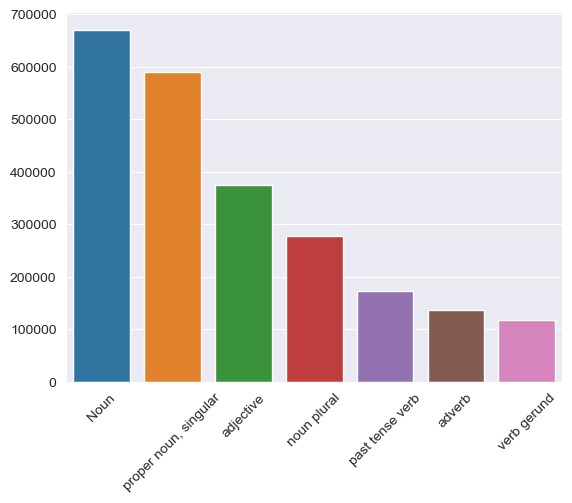

In [16]:
from nltk import pos_tag
tags= pos_tag(corpus1)
tags=[x for l in tags for x in l]
counter=Counter(tags)
common_tags = counter.most_common(7)
x = [tag[0] for tag in common_tags]
y = [tag[1] for tag in common_tags]
s = sns.barplot(x=x,y=y)
s.set_xticklabels(['Noun', 'proper noun, singular', 'adjective', 'noun plural',
                   'past tense verb', 'adverb', 'verb gerund'],rotation =45)

## CountVectorizer

### Creating training and test sets

In [17]:
y = df.label
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

### Initializing a CountVectorizer object

In [18]:
count_vectorizer = CountVectorizer(stop_words='english')

### Transforming the training data using only the 'text' column values: count_train 

In [19]:
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)


###  Printing the first 10 features 

In [20]:
print(count_vectorizer.get_feature_names_out()[:10])

['00' '000' '0000' '00000031' '000035' '00006' '0001' '0001pt' '000ft'
 '000km']


## TfidfVectorizer

### Initializing a TfidfVectorizer object: tfidf_vectorizer

In [21]:

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)


### Transforming the training data: tfidf_train 

In [22]:

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
print(tfidf_train)

  (1, 36831)	0.10772488937433063
  (1, 47506)	0.1453906087746004
  (1, 38823)	0.06048803110658641
  (1, 25684)	0.10304209221897535
  (1, 21568)	0.10079209195663975
  (1, 36087)	0.1264867985438989
  (1, 16814)	0.10404977746548134
  (1, 49203)	0.16727408617843761
  (1, 25686)	0.13550453594288978
  (1, 15927)	0.4973826512693339
  (1, 29531)	0.1454406205718244
  (1, 8399)	0.08729542880625331
  (1, 42534)	0.06081715886809214
  (1, 21881)	0.21271688045815967
  (1, 35256)	0.12628385718450852
  (1, 35783)	0.3090269081882796
  (1, 51896)	0.11596517664605863
  (1, 44520)	0.4973826512693339
  (1, 15924)	0.3479045460649077
  (1, 50628)	0.061296988343109565
  (1, 54177)	0.1378262914471113
  (1, 12105)	0.1500806646147686
  (1, 42470)	0.07711040274149523
  (2, 9445)	0.22180388050235564
  (2, 8779)	0.19767342113068423
  :	:
  (4243, 30464)	0.032161542218569955
  (4243, 35836)	0.05588497635835917
  (4243, 48084)	0.032785339176678384
  (4243, 22146)	0.027343369111012244
  (4243, 9042)	0.0580186579694780

### Transform the test data: tfidf_test 

In [23]:

tfidf_test = tfidf_vectorizer.transform(X_test)

### Printing the first 10 features

In [24]:

print(tfidf_vectorizer.get_feature_names_out()[:10])

['00' '000' '0000' '00000031' '000035' '00006' '0001' '0001pt' '000ft'
 '000km']


### Printing the first 5 vectors of the tfidf training data

In [25]:

print(tfidf_train.A[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Creating the CountVectorizer DataFrame

In [26]:

count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names_out())

### Creating the TfidfVectorizer DataFrame

In [27]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names_out())

In [28]:
# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))


   00  000  0000  00000031  000035  00006  0001  0001pt  000ft  000km  ...  \
0   0    0     0         0       0      0     0       0      0      0  ...   
1   0    0     0         0       0      0     0       0      0      0  ...   
2   0    0     0         0       0      0     0       0      0      0  ...   
3   0    0     0         0       0      0     0       0      0      0  ...   
4   0    0     0         0       0      0     0       0      0      0  ...   

   حلب  عربي  عن  لم  ما  محاولات  من  هذا  والمرضى  ยงade  
0    0     0   0   0   0        0   0    0        0      0  
1    0     0   0   0   0        0   0    0        0      0  
2    0     0   0   0   0        0   0    0        0      0  
3    0     0   0   0   0        0   0    0        0      0  
4    0     0   0   0   0        0   0    0        0      0  

[5 rows x 56922 columns]
    00  000  0000  00000031  000035  00006  0001  0001pt  000ft  000km  ...  \
0  0.0  0.0   0.0       0.0     0.0    0.0   0.0     0.0    

## Instantiate a Multinomial Naive Bayes classifier

In [29]:
nb_classifier = MultinomialNB()
# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)
# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)
# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)


0.893352462936394


## Confusion matrix for count vectorizer 

[[ 865  143]
 [  80 1003]]


Text(52.722222222222214, 0.5, 'Real')

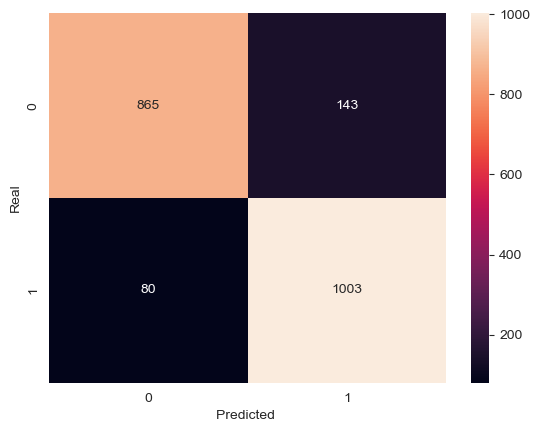

In [30]:
cm_count_nav = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm_count_nav)
sns.heatmap(cm_count_nav, annot=True,
            fmt='', cmap='rocket')

plt.xlabel('Predicted ')
plt.ylabel('Real')

## Training and testing model with TfidfVectorizer

In [31]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.8565279770444764
[[ 739  269]
 [  31 1052]]


## Confusion matrix for tfid

Text(52.722222222222214, 0.5, 'Real')

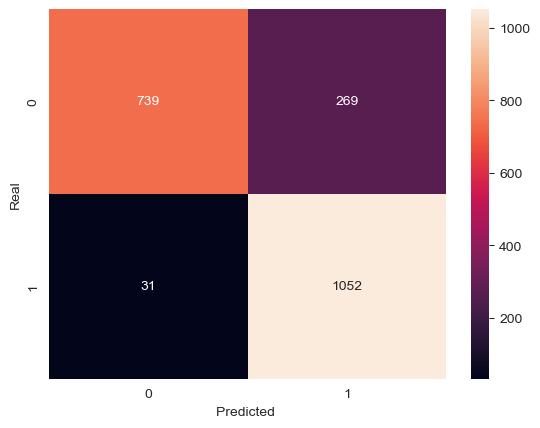

In [32]:
sns.heatmap(cm, annot=True,
            fmt='', cmap='rocket')

plt.xlabel('Predicted ')
plt.ylabel('Real')

## Checking the improvement to be made in the model (manual hyper parameter tunning ) 

In [33]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()
    

Alpha:  0.0
Score:  0.8813964610234337

Alpha:  0.1
Score:  0.8976566236250598

Alpha:  0.2
Score:  0.8938307030129125

Alpha:  0.30000000000000004
Score:  0.8900047824007652

Alpha:  0.4
Score:  0.8857006217120995

Alpha:  0.5
Score:  0.8842659014825442

Alpha:  0.6000000000000001
Score:  0.874701099952176

Alpha:  0.7000000000000001
Score:  0.8703969392635102

Alpha:  0.8
Score:  0.8660927785748446

Alpha:  0.9
Score:  0.8589191774270684


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


## Hyper parameter tunning using grid cv

In [44]:
from sklearn.metrics import accuracy_score
param_grid = {'alpha': np.arange(0.01, 1.01, 0.1)}
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5)
grid_search.fit(count_train, y_train)
best_model = grid_search.best_estimator_
print(f'best model : {best_model}')
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")
predictions = best_model.predict(count_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the best model: {accuracy}")


best model : MultinomialNB(alpha=0.11)
Best Alpha: 0.11
Accuracy of the best model: 0.8938307030129125


## Model inspection 

In [ ]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.feature_log_prob_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:40])
print("")
# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-40:])

